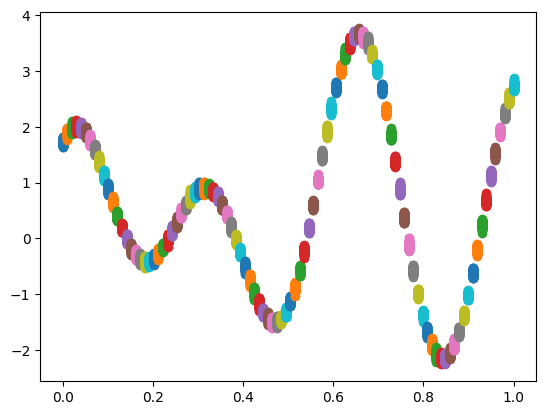

CUDA Available: False


In [1]:
from data_utils import generate_data_from_function
from experiment_utils import generate_legendre_inner_product_integrand, product_of_legendre_polynomials
import numpy as np
import matplotlib.pyplot as plt
import torch

f = lambda x: np.sqrt(2) * np.sin(4 * np.pi * x) + np.sqrt(3) * np.cos(6 * np.pi * x) + x
T, X = generate_data_from_function(f, num_samples=500, sparsity=0.3, noise_std=0.04)
time_values = np.linspace(0, 1, T.shape[1])

plt.plot(T, X, "o")
plt.show()

print(f"CUDA Available: {torch.cuda.is_available()}")  # Should return True

In [ ]:
from neuralint import NeuralInt
from data_utils import get_dataloaders
from neuralint_utils import load_model, train

dataloaders = get_dataloaders(T, X)
model = NeuralInt(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-8)
epoch, loss = load_model(model, optimizer=optimizer)
train(model, optimizer, dataloaders["train"], dataloaders["validate"], num_epochs=500, starting_epoch = epoch, best_val_loss = loss)

In [ ]:
from neuralint import get_imputation_from_checkpoint

subset = dataloaders["test"].dataset
T_test, X_test, _ = subset.dataset[subset.indices]

X_imputed_transformer, X_imputed_neuralint, integration_fn = get_imputation_from_checkpoint(T_test, X_test)

In [ ]:
X_imputed_mean_neuralint = torch.mean(X_imputed_neuralint, axis=0).detach().numpy()
X_imputed_mean_transformer = torch.mean(X_imputed_transformer, axis=0).detach().numpy()

In [ ]:
np_imputed_neuralint = X_imputed_neuralint[0].detach().numpy()

# Compute MSE using PyTorch
mse_neuralint = torch.nn.functional.mse_loss(
    torch.tensor(np_imputed_neuralint), torch.tensor(f(time_values))
).item()

mse_transformer = torch.nn.functional.mse_loss(
    torch.tensor(np_imputed_neuralint), torch.tensor(f(time_values))
).item()

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot NeuralInt with reference to True Function
axes[0].plot(time_values, np_imputed_neuralint, color="black", label="Diff(NeuralInt(t))")
axes[0].plot(time_values, f(time_values), linestyle="dashed", color="gray", alpha=0.5, label="X(t) (True Function, Reference)")
axes[0].plot(time_values, X[0], "o", color="orange", label="Sampled Points")
axes[0].set_title("Diff(NeuralInt(t))")
axes[0].set_xlabel("t")
axes[0].set_ylabel("X(t)")
axes[0].legend()
axes[0].text(0.5, -0.2, f"MSE: {mse_neuralint:.6f}", ha='center', transform=axes[0].transAxes, fontsize=12)

# Plot Transformer with reference to True Function
axes[1].plot(time_values, np_imputed_neuralint, color="blue", label="Transformer(t)")
axes[1].plot(time_values, f(time_values), linestyle="dashed", color="gray", alpha=0.5, label="X(t) (True Function, Reference)")
axes[1].plot(time_values, X[0], "o", color="orange", label="Sampled Points")
axes[1].set_title("Transformer")
axes[1].set_xlabel("t")
axes[1].legend()
axes[1].text(0.5, -0.2, f"MSE: {mse_transformer:.6f}", ha='center', transform=axes[1].transAxes, fontsize=12)

# Plot Actual Function with references to NeuralInt and Transformer
axes[2].plot(time_values, f(time_values), color="red", label="X(t) (True Function)")
axes[2].plot(time_values, X[0], "o", color="orange", label="Sampled Points")
axes[2].set_title("X(t) (True Function)")
axes[2].set_xlabel("t")
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
mean_integration_function = torch.mean(integration_fn, axis=0)
true_integral = lambda x: (3 * np.pi * x**2 + 3 * np.sqrt(2) * np.sin(2 * np.pi * x)**2 + np.sqrt(3) * np.sin(6 * np.pi * x)) / (6 * np.pi)

# Convert PyTorch tensor to NumPy for plotting
mean_integration_np = mean_integration_function.detach().numpy()
true_integral_np = true_integral(time_values)

# Compute Mean Squared Error (MSE) using PyTorch
mse = torch.nn.functional.mse_loss(
    torch.tensor(mean_integration_np), torch.tensor(true_integral_np)
).item()

# Plot both functions side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Mean Integration Function with faded dashed True Integral
axs[0].plot(time_values, mean_integration_np, label="Mean Intg(t)", color="blue")
axs[0].plot(time_values, true_integral_np, linestyle="dashed", color="gray", alpha=0.5, label="True Integral (Reference)")
axs[0].set_title("Mean Intg(t)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Value")
axs[0].legend()

# Plot True Integral with faded dashed Mean Integration Function
axs[1].plot(time_values, true_integral_np, label="True Integral", color="red")
axs[1].plot(time_values, mean_integration_np, linestyle="dashed", color="gray", alpha=0.5, label="Mean Intg(t) (Reference)")
axs[1].set_title("True Integral")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Value")
axs[1].legend()

# Display the MSE at the bottom center of the figure
fig.text(0.5, 0.01, f"MSE: {mse:.6f}", ha='center', fontsize=12)

# Show the plots
plt.tight_layout()
plt.show()
